<a href="https://colab.research.google.com/github/eitellauria/PTcausal/blob/main/notebooks/Bayesian_hierarchical_PT_instructor_influence_on_student_grades__ipynb_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bayesian hierarchical regression - PT instructor influence on student grades

v  2.0

5/12/2025, 2:18 PM ET




In [ ]:
# in case the "invalid format delete widget metadata..." error pops up. (not sure where this is coming from)
# new notebook has to be downloaded from colab, reloaded and saved to github.

import nbformat
from google.colab import _message
notebook = _message.blocking_request('get_ipynb')['ipynb']

if 'widgets' in notebook['metadata']:
    del notebook['metadata']['widgets']

with open('/content/Bayesian_hierarchical_PT_instructor_influence_on_student_grades__ipynb_20.ipynb', 'w') as f:
    nbformat.write(nbformat.from_dict(notebook), f)

In [ ]:
#  import pandas as pd
#  import numpy as np
#  print("np:",np.__version__)

In [ ]:
!pip install -q arviz>=0.12.0 formulae>=0.5.3 graphviz pandas>=1.0.0 pymc>=5.18.0
!pip install -q bambi

In [ ]:
import warnings


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import bambi as bmb
import pymc as pm
import time


np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

warnings.filterwarnings("ignore", category=FutureWarning)

##  VERY IMPORTANT !!==========================================================================
freshmen_data = False


## Utility functions


In [ ]:
def calculate_pt_metrics(df, min_sections=3):
    """
    Calculate section based PT faculty percentages
    for each course, and add these metrics to the original dataframe.

    Parametros:
    df - DataFrame containing student-level data with COURSE, COURSE_SECTION, PT fields
    min_sections - Minimum number of sections for a course to be included (optional filter)

    Returns:
    DataFrame with PT metrics added, filtered to include only courses with sufficient sections
    """
    import pandas as pd


    sections = df[['COURSE', 'COURSE_SECTION', 'TERM_CODE', 'PT', 'ENROLLMENT']].drop_duplicates()


    section_counts = sections.groupby('COURSE').size().reset_index(name='TOTAL_SECTIONS')
    pt_sections = sections[sections['PT'] == 1].groupby('COURSE').size().reset_index(name='PT_SECTIONS')

    course_metrics = pd.merge(section_counts, pt_sections, on='COURSE', how='left').fillna(0)
    course_metrics['TOTAL_SECTIONS'] = course_metrics['TOTAL_SECTIONS'].astype(int)
    course_metrics['PT_SECTIONS'] = course_metrics['PT_SECTIONS'].astype(int)
    course_metrics['PCT_PT_SECTION'] = (course_metrics['PT_SECTIONS'] / course_metrics['TOTAL_SECTIONS'] * 100).round(1)


    if min_sections > 0:
        print(f"Filtering courses to include those with at least {min_sections} sections")
        filtered_course_metrics = course_metrics[course_metrics['TOTAL_SECTIONS'] >= min_sections].copy()
        print(f"Retained {len(filtered_course_metrics)} out of {len(course_metrics)} unique courses after filtering")
    else:
        filtered_course_metrics = course_metrics


    df_with_metrics = df.copy()


    section_lookup = dict(zip(filtered_course_metrics['COURSE'], filtered_course_metrics['PCT_PT_SECTION']))
    df_with_metrics['PCT_PT_SECTION'] = df_with_metrics['COURSE'].map(section_lookup)

    total_sections_lookup = dict(zip(filtered_course_metrics['COURSE'], filtered_course_metrics['TOTAL_SECTIONS']))
    df_with_metrics['TOTAL_SECTIONS'] = df_with_metrics['COURSE'].map(total_sections_lookup)


    filtered_df = df_with_metrics[df_with_metrics['PCT_PT_SECTION'].notna()].copy()

    if min_sections > 0:
        print(f"Retained {len(filtered_df)} out of {len(df)} student records after filtering")

    return filtered_df

#----------------------------------------------------------------------------------------------------------------------------------------
def check_positivity_and_filter(df, min_threshold=5, max_threshold=95):
    """
    Check positivity assumption and filter out courses that violate it

    Parametros:
        df - DataFrame with PCT_PT_SECTION already calculated
        min_threshold - Minimum percentage for positivity
        max_threshold - Maximum percentage for positivity

    Returns:
    Filtered DataFrame and summary statistics
    """

    extreme_low_courses = df[df['PCT_PT_SECTION'] < min_threshold]['COURSE'].unique()
    extreme_high_courses = df[df['PCT_PT_SECTION'] > max_threshold]['COURSE'].unique()


    low_count = df[df['COURSE'].isin(extreme_low_courses)].shape[0]
    high_count = df[df['COURSE'].isin(extreme_high_courses)].shape[0]


    print(f"Courses with <{min_threshold}% PT faculty: {len(extreme_low_courses)} courses ({low_count} records)")
    print(f"Courses with >{max_threshold}% PT faculty: {len(extreme_high_courses)} courses ({high_count} records)")


    violated_courses = list(extreme_low_courses) + list(extreme_high_courses)
    df_filtered = df[~df['COURSE'].isin(violated_courses)].copy()


    removed = len(df) - len(df_filtered)
    print(f"\nRemoved {removed} observations ({removed/len(df)*100:.1f}%) to satisfy positivity")
    print(f"Retained {len(df_filtered)} observations")


    if len(df_filtered) > 0:
      print("\nPCT_PT_SECTION distribution after filtering:")
      print(df_filtered['PCT_PT_SECTION'].describe([0.1, 0.25, 0.5, 0.75, 0.9]))

    return df_filtered

#---------------------------------------------------------------------------------------------------------------------------------------------

def display_metrics_old(df):

  section_info = df[['COURSE_SECTION', 'PT', 'ENROLLMENT']].drop_duplicates()


  summary = section_info.groupby('PT').agg(
    NUM_SECTIONS=('COURSE_SECTION', 'nunique'),
    NUM_STUDENTS=('ENROLLMENT', 'sum'),
    MEAN_ENROLLMENT=('ENROLLMENT', 'mean'),
    MEDIAN_ENROLLMENT=('ENROLLMENT', 'median'),
    STD_ENROLLMENT=('ENROLLMENT', 'std')
  ).reset_index()


  summary['PCT_SECTIONS'] = (summary['NUM_SECTIONS'] / summary['NUM_SECTIONS'].sum() * 100).round(1)
  summary['PCT_STUDENTS'] = (summary['NUM_STUDENTS'] / summary['NUM_STUDENTS'].sum() * 100).round(1)
  summary['FACULTY_TYPE'] = summary['PT'].map({0: 'Full-Time', 1: 'Part-Time'})


  cols = [
    'FACULTY_TYPE', 'NUM_SECTIONS', 'PCT_SECTIONS',
    'NUM_STUDENTS', 'PCT_STUDENTS',
    'MEAN_ENROLLMENT', 'MEDIAN_ENROLLMENT', 'STD_ENROLLMENT'
  ]
  final_summary = summary[cols]


  print("\nSummary of Section and Enrollment Statistics by Faculty Type:")
  print(final_summary)


  plt.figure(figsize=(12, 6))

  plt.subplot(1, 1, 1)
  sns.histplot(df['PCT_PT_SECTION'], bins=20, kde=True)
  plt.title('Distribution of PT Section Percentages')
  plt.xlabel('Percentage of Sections Taught by PT Faculty')
  return final_summary

 #---------------------------------------------------------------------------------------------------------------------------------------

def display_metrics(df):

  section_info = df[['COURSE_SECTION', 'PT', 'ENROLLMENT']].drop_duplicates()


  summary = section_info.groupby('PT').agg(
    NUM_SECTIONS=('COURSE_SECTION', 'nunique'),
    NUM_STUDENTS=('ENROLLMENT', 'sum'),
    MEAN_ENROLLMENT=('ENROLLMENT', 'mean'),
    MEDIAN_ENROLLMENT=('ENROLLMENT', 'median'),
    STD_ENROLLMENT=('ENROLLMENT', 'std')
  ).reset_index()


  summary['PCT_SECTIONS'] = (summary['NUM_SECTIONS'] / summary['NUM_SECTIONS'].sum() * 100).round(1)
  summary['PCT_STUDENTS'] = (summary['NUM_STUDENTS'] / summary['NUM_STUDENTS'].sum() * 100).round(1)
  summary['FACULTY_TYPE'] = summary['PT'].map({0: 'Full-Time', 1: 'Part-Time'})


  cols = [
    'FACULTY_TYPE', 'NUM_SECTIONS', 'PCT_SECTIONS',
    'NUM_STUDENTS', 'PCT_STUDENTS',
    'MEAN_ENROLLMENT', 'MEDIAN_ENROLLMENT', 'STD_ENROLLMENT'
  ]
  final_summary = summary[cols]


  print("\nSummary of Section and Enrollment Statistics by Faculty Type:")
  print(final_summary)


  plt.figure(figsize=(12, 6))

  plt.subplot(1, 1, 1)
  sns.histplot(df['PCT_PT_SECTION'], bins=20, kde=True)
  plt.title('Distribution of PT Section Percentages', fontsize=14)
  plt.xlabel('Percentage of Sections Taught by PT Faculty', fontsize=12)
  plt.ylabel('Count', fontsize=12)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)

  plt.tight_layout()


#----------------------------------------------------------------------------------------------------------------------------------------

import statsmodels.formula.api as smf

def estimate_cate_all_students_linear(data):
    # HSGPA bins
    data["HSGPA_BIN"] = pd.qcut(data["HSGPA"], q=5, labels=["Q1", "Q2", "Q3", "Q4", "Q5"])
    _, bin_edges = pd.qcut(data["HSGPA"], q=5, retbins=True)
    range_labels = [f"{round(bin_edges[i], 2)} – {round(bin_edges[i+1], 2)}" for i in range(len(bin_edges)-1)]
    label_map = dict(zip(["Q1", "Q2", "Q3", "Q4", "Q5"], range_labels))


    def estimate_cate_for_group(subset_df, label):
        if subset_df.empty:
            print(f"{label}: No data in this group.")
            return None
        try:
            model = smf.ols("GRADE_FINAL ~ PT + PRE_COVID + ENROLLMENT + PCT_PT_SECTION + HSGPA + FEMALE + PELLSTATUS + RACE_MINORITY + AGE + C(CLASS)", data=subset_df).fit()
            coef = model.params.get("PT", np.nan)
            print(f"CATE for {label}: {coef:.4f}")
            return {"Group": label, "CATE": coef}
        except Exception as e:
            print(f"{label}: Error - {e}")
            return None

    cate_results = []


    for label in data["HSGPA_BIN"].cat.categories:
        subset = data[data["HSGPA_BIN"] == label]
        readable_label = f"{label} (HSGPA: {label_map[label]})"
        result = estimate_cate_for_group(subset, readable_label)
        if result:
            cate_results.append(result)


    binary_vars = {
        "FEMALE": ["Female", "Male"],
        "RACE_MINORITY": ["Minority", "Non-Minority"],
        "PELLSTATUS": ["Pell-Eligible", "Non-Pell"]
    }

    for var, labels in binary_vars.items():
        for val, label in zip([1, 0], labels):
            subset = data[data[var] == val]
            result = estimate_cate_for_group(subset, label)
            if result:
                cate_results.append(result)


    class_levels = ["FR", "SO", "JR", "SR"]
    for level in class_levels:
        subset = data[data["CLASS"] == level]
        result = estimate_cate_for_group(subset, f"CLASS {level}")
        if result:
            cate_results.append(result)


    groups = [entry["Group"] for entry in cate_results]
    cate_values = [entry["CATE"] for entry in cate_results]
    colors = (
        ["#4575b4"] * 5 +          # HSGPA bins
        ["#91bfdb", "#fc8d59"] +   # Gender
        ["#91bfdb", "#fc8d59"] +   # Race
        ["#91bfdb", "#fc8d59"] +   # Pell
        ["#d73027", "#fc8d59", "#fee090", "#e0f3f8"]  # CLASS
    )

    plt.figure(figsize=(14, 6))
    bars = plt.bar(groups, cate_values, color=colors)
    plt.axhline(0, color="black", linestyle="--", linewidth=1)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.2f}",
                 ha='center', va='bottom', fontsize=9)
    plt.title("Conditional Average Treatment Effects (CATEs) by Student Subgroup")
    plt.ylabel("Estimated CATE (Effect of PT Instructor on Final Grade)")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

#--------------------------------------------------------------------------------------------------------------------------
import re
def calculate_rope_percentage(posterior_samples, rope_min, rope_max):
    """
    Calculate the percentage of posterior samples that fall within the ROPE.

    Parameters:
    - posterior_samples: Array of posterior samples for a parameter.
    - rope_min: Minimum value of the ROPE.
    - rope_max: Maximum value of the ROPE.

    Returns:
    - Percentage of posterior samples within the ROPE.
    """
    within_rope = np.logical_and(posterior_samples >= rope_min, posterior_samples <= rope_max)
    return 100 * np.mean(within_rope)

#--------------------------------------------------------------------------------------------------------------------------

def compute_hdi_rope_overlap(hdi_min, hdi_max, rope_min, rope_max):
    """
    Computes the percentage overlap between the HDI and ROPE.

    Parameters:
    - hdi_min: Lower bound of the HDI.
    - hdi_max: Upper bound of the HDI.
    - rope_min: Minimum value of the ROPE.
    - rope_max: Maximum value of the ROPE.

    Returns:
    - Percentage overlap between the HDI and ROPE.
    """
    overlap_min = max(hdi_min, rope_min)
    overlap_max = min(hdi_max, rope_max)
    if overlap_min < overlap_max:
        return 100 * (overlap_max - overlap_min) / (hdi_max - hdi_min)
    return 0.0

#--------------------------------------------------------------------------------------------------------------------------

def filter_var_names(idata, exclude_patterns, include_intercept=True):
    """
    Filter variable names from an ArviZ InferenceData object based on exclusion patterns.

    Parameters:
    - idata: InferenceData object from ArviZ.
    - exclude_patterns: List of regex patterns to exclude.
    - include_intercept: Boolean indicating whether to include 'Intercept' in the result.

    Returns:
    - List of filtered variable names.
    """

    all_var_names = list(idata.posterior.data_vars)


    exclude_regex = [re.compile(pattern) for pattern in exclude_patterns]


    filtered_var_names = [
        var for var in all_var_names
        if not any(regex.match(var) for regex in exclude_regex)
    ]


    if include_intercept and 'Intercept' in all_var_names and 'Intercept' not in filtered_var_names:
        filtered_var_names.append('Intercept')

    return filtered_var_names

#--------------------------------------------------------------------------------------------------------------------------

def filter_var_names_report(idata, include_intercept=True):
    """
    Return a list of variable names including:
    - Fixed effects (no '|' or '[')
    - Intercept
    - Group-level sd/cov parameters
    """
    all_vars = list(idata.posterior.data_vars)

    filtered_vars = []
    for var in all_vars:

        if "|" not in var and "[" not in var:
            filtered_vars.append(var)


        elif var.startswith("sd(") or var.startswith("cov("):
            filtered_vars.append(var)

    if include_intercept and "Intercept" in all_vars and "Intercept" not in filtered_vars:
        filtered_vars.append("Intercept")

    return filtered_vars

#--------------------------------------------------------------------------------------------------------------------------

def add_rope_info(idata, var_names, default_rope_min, default_rope_max, ropes=None):
    """
    Adds columns to the ArviZ summary DataFrame indicating the percentage of
    posterior samples within the ROPE and the percentage overlap between the 95% HDI and the ROPE.

    Parameters:
    - idata: InferenceData object from ArviZ.
    - var_names: List of variable names to include in the summary.
    - default_rope_min: Default minimum value of the ROPE.
    - default_rope_max: Default maximum value of the ROPE.
    - ropes: Optional list of tuples specifying (rope_min, rope_max) for each variable.

    Returns:
    - Updated DataFrame with additional columns for the percentage of posterior samples within the ROPE
      and the percentage overlap between the HDI and ROPE.
    """
    summary_df = az.summary(idata, var_names=var_names, hdi_prob=0.95)  # should typically be 0.95 or 0.89
    rope_percentages = []
    hdi_rope_overlaps = []

    for var in summary_df.index:
        base_var = var.split('[')[0]
        if ropes and base_var in var_names:
            rope_idx = var_names.index(base_var)
            rope_min, rope_max = ropes[rope_idx]
        else:
            rope_min, rope_max = default_rope_min, default_rope_max

        # Handle dumies
        try:
            posterior_samples = idata.posterior[var].values.flatten()
        except KeyError:
            base_var = var.split('[')[0]
            posterior_samples = idata.posterior[base_var].values.flatten()

        rope_percentage = calculate_rope_percentage(posterior_samples, rope_min, rope_max)
        rope_percentages.append(rope_percentage)

        hdi_min = summary_df.loc[var, 'hdi_2.5%']
        hdi_max = summary_df.loc[var, 'hdi_97.5%']
        hdi_rope_overlap = compute_hdi_rope_overlap(hdi_min, hdi_max, rope_min, rope_max)
        hdi_rope_overlaps.append(hdi_rope_overlap)

    #summary_df['% posterior samples within ROPE'] = rope_percentages
    summary_df['%  95% HDI within ROPE'] = hdi_rope_overlaps

    if 'Intercept' in summary_df.index:
        intercept_row = summary_df.loc['Intercept']
        summary_df = summary_df.drop('Intercept')
        summary_df = pd.concat([pd.DataFrame([intercept_row]), summary_df])


    return summary_df

#-------------------------------------------------------------------------------------------------------------------------
def rename_random_effects_for_display(summary_df, square_sds=True):
    """
    Rename random effect components in the summary DataFrame to match
    statmodels-style output, optionally converting SDs to variances.

    Parameters:
    - summary_df: DataFrame returned by `add_rope_info`.
    - square_sds: If True, squares standard deviations to get variances.

    Returns:
    - Modified DataFrame with renamed index and squared variance values (if selected).
    """
    renaming_map = {
        "sd(COURSE|Intercept)": "Group Var",
        "sd(COURSE|PT)": "PT Var",
        "cov(COURSE|Intercept,PT)": "Group x PT Cov"
    }

    summary_df = summary_df.copy()

    for original, renamed in renaming_map.items():
        if original in summary_df.index:
            if square_sds:

                for col in ["mean", "sd", "hdi_2.5%", "hdi_97.5%"]:
                    if col in summary_df.columns:
                        summary_df.at[original, col] = summary_df.at[original, col] ** 2
            summary_df.rename(index={original: renamed}, inplace=True)

    return summary_df

#--------------------------------------------------------------------------------------------------------------------------
def extract_group_variance_summary(fitted, group="COURSE"):
    import numpy as np
    import pandas as pd
    from scipy.stats import mstats


    intercept_sd = fitted.posterior[f"1|{group}_sigma"].values.flatten()
    pt_sd = fitted.posterior[f"PT|{group}_sigma"].values.flatten()


    group_var = intercept_sd ** 2
    pt_var = pt_sd ** 2


    intercept_samples = fitted.posterior[f"1|{group}"].values.reshape(-1, 120)  # (samples, courses)
    pt_samples = fitted.posterior[f"PT|{group}"].values.reshape(-1, 120)


    covariances = np.array([
        np.cov(intercept_samples[:, i], pt_samples[:, i])[0, 1]
        for i in range(intercept_samples.shape[1])
    ])

    # This gives a distribution of covariance estimates across courses, based on draws


    def summarize(samples):
        return {
            "mean": np.mean(samples),
            "sd": np.std(samples),
            "hdi_2.5%": np.percentile(samples, 2.5),
            "hdi_97.5%": np.percentile(samples, 97.5),
        }

    summary = pd.DataFrame.from_dict({
        "Group Var": summarize(group_var),
        "PT Var": summarize(pt_var),
        "Group x PT Cov": summarize(covariances)
    }, orient="index")

    return summary




#==========================================================================================================================


## Load  and process data

In [ ]:
#from google.colab import drive
#drive.mount('/gdrive')

#NOTE: data access is masked as the data is not publicly available.


!rm  student_allcourses
!wget https://foxweb.marist.edu/users/Research/PTFgrades/student_allcourses.zip
!unzip student_allcourses.zip

In [ ]:
df_source = pd.read_csv('student_allcourses.csv')
df_source.info()
#df_source.groupby('CLASS').size()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491267 entries, 0 to 491266
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SCHOOL             491267 non-null  object 
 1   TERM_CODE          491267 non-null  int64  
 2   COURSE_SECTION     491267 non-null  object 
 3   FT                 491267 non-null  int64  
 4   FAC_STATUS         491267 non-null  object 
 5   ENROLLMENT         491267 non-null  int64  
 6   COURSE             491267 non-null  object 
 7   CWID               491267 non-null  int64  
 8   AGE                491267 non-null  int64  
 9   SEX                491263 non-null  object 
 10  CLASS              491267 non-null  object 
 11  LAST_NAME          491267 non-null  object 
 12  FIRST_NAME         491267 non-null  object 
 13  MI                 385501 non-null  object 
 14  PELLSTATUS         491267 non-null  object 
 15  STUDENT_TYPE       491267 non-null  object 
 16  ST

In [ ]:
# Load the data

enrollment_counts = df_source.groupby(['TERM_CODE', 'COURSE_SECTION']).size().reset_index(name='ENROLLMENT_COUNT')


result_df = pd.merge(df_source, enrollment_counts, on=['TERM_CODE', 'COURSE_SECTION'], how='left')


result_df['ENROLLMENT'] = result_df['ENROLLMENT_COUNT']
result_df = result_df.drop('ENROLLMENT_COUNT', axis=1)


result_df['PT'] = np.where(result_df['FT']==0,1,0)
result_df = result_df.drop('FT', axis=1)


result_df = result_df.drop(['GPA_U','HOURS_PASSED_G','STANDING_DESC','MI'], axis=1)


result_df=result_df.dropna().copy()


result_df=result_df.query("HSGPA > 0.1 & HSGPA<=4.0").copy()


letter_grades = ('A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'F')
grade_mapping = {'A': 4.0, 'A-': 3.7, 'B+': 3.3, 'B': 3.0, 'B-': 2.7,'C+': 2.3, 'C': 2.0, 'C-': 1.7, 'D+': 1.3, 'D': 1.0, 'F': 0.0}

result_df = result_df[result_df['GRADE_FINAL'].isin(letter_grades)].copy()
result_df['LETTER_GRADE_FINAL'] = result_df['GRADE_FINAL']
result_df['GRADE_FINAL'] = result_df['GRADE_FINAL'].map(grade_mapping)



result_df['TERM_CODE'] = result_df['TERM_CODE'].astype(str)
result_df['COURSE_SECTION']=result_df['COURSE']
result_df['COURSE'] = result_df['COURSE_SECTION'].str[:-3]
result_df['FRESHMEN'] = np.where(result_df['CLASS']=="FR", 1, 0)
result_df['RACE_MINORITY']=np.where(result_df['RACE_CODE']=='W',0,1)
result_df['FEMALE']=np.where(result_df['SEX']=='F',1,0)
result_df['PELLSTATUS']=np.where(result_df['PELLSTATUS']=='YES',1,0)
result_df['POOR_PERFORMANCE'] = np.where(result_df['GRADE_FINAL'].isin(['C-', 'D+', 'D', 'D-', 'F']), 1, 0)
result_df['PRE_COVID'] = (result_df['TERM_CODE'] < '202020').astype(int)
result_df = result_df.query("CLASS!='GR'" ).copy()

if freshmen_data:
    result_df = result_df.query("FIRST_SEMESTER==1 & FRESHMEN==1" ).copy()
    result_df= result_df[result_df['TERM_CODE'].str.endswith('40')].copy()
    df0 = result_df[['TERM_CODE','PRE_COVID','COURSE','COURSE_SECTION', 'PT','ENROLLMENT', 'HSGPA', 'FEMALE', 'PELLSTATUS', 'RACE_MINORITY', 'GRADE_FINAL']].copy()
else:
    df0 = result_df[['TERM_CODE','PRE_COVID','COURSE','COURSE_SECTION', 'PT','ENROLLMENT','AGE','CLASS', 'HSGPA', 'FEMALE', 'PELLSTATUS', 'RACE_MINORITY', 'GRADE_FINAL']].copy()
df0.info()


<class 'pandas.core.frame.DataFrame'>
Index: 64174 entries, 22365 to 491266
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TERM_CODE       64174 non-null  object 
 1   PRE_COVID       64174 non-null  int64  
 2   COURSE          64174 non-null  object 
 3   COURSE_SECTION  64174 non-null  object 
 4   PT              64174 non-null  int64  
 5   ENROLLMENT      64174 non-null  int64  
 6   HSGPA           64174 non-null  float64
 7   FEMALE          64174 non-null  int64  
 8   PELLSTATUS      64174 non-null  int64  
 9   RACE_MINORITY   64174 non-null  int64  
 10  GRADE_FINAL     64174 non-null  float64
dtypes: float64(2), int64(6), object(3)
memory usage: 5.9+ MB


In [ ]:
result_df.groupby(['CLASS','PT']).size()

CLASS  PT
FR     0     29998
       1     34176
dtype: int64

## Calculate metrics


In [ ]:
df_with_metrics = calculate_pt_metrics(df0)

Filtering courses to include those with at least 3 sections
Retained 236 out of 382 unique courses after filtering
Retained 63534 out of 64174 student records after filtering


## Check positivity and filter data

In [ ]:
df=check_positivity_and_filter(df_with_metrics)
df.info()

Courses with <5% PT faculty: 53 courses (10457 records)
Courses with >95% PT faculty: 63 courses (4939 records)

Removed 15396 observations (24.2%) to satisfy positivity
Retained 48138 observations

PCT_PT_SECTION distribution after filtering:
count    48138.000000
mean        60.346986
std         21.824948
min          6.100000
10%         22.400000
25%         39.700000
50%         66.100000
75%         76.500000
90%         80.100000
max         94.700000
Name: PCT_PT_SECTION, dtype: float64
<class 'pandas.core.frame.DataFrame'>
Index: 48138 entries, 22365 to 491266
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TERM_CODE       48138 non-null  object 
 1   PRE_COVID       48138 non-null  int64  
 2   COURSE          48138 non-null  object 
 3   COURSE_SECTION  48138 non-null  object 
 4   PT              48138 non-null  int64  
 5   ENROLLMENT      48138 non-null  int64  
 6   HSGPA           48138 non

---------------------------------------------------------------------------------------------------
# Analysis

In [ ]:
if freshmen_data:
  data = df[['PT', 'COURSE',	'COURSE_SECTION', 'PRE_COVID','ENROLLMENT','PCT_PT_SECTION', 'HSGPA','FEMALE', 'PELLSTATUS', 'RACE_MINORITY','GRADE_FINAL']]
else:
  data = df[['PT', 'COURSE',	'COURSE_SECTION', 'PRE_COVID','ENROLLMENT','PCT_PT_SECTION', 'AGE', 'CLASS', 'HSGPA','FEMALE', 'PELLSTATUS', 'RACE_MINORITY','GRADE_FINAL']]

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48138 entries, 22365 to 491266
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PT              48138 non-null  int64  
 1   COURSE          48138 non-null  object 
 2   COURSE_SECTION  48138 non-null  object 
 3   PRE_COVID       48138 non-null  int64  
 4   ENROLLMENT      48138 non-null  int64  
 5   PCT_PT_SECTION  48138 non-null  float64
 6   HSGPA           48138 non-null  float64
 7   FEMALE          48138 non-null  int64  
 8   PELLSTATUS      48138 non-null  int64  
 9   RACE_MINORITY   48138 non-null  int64  
 10  GRADE_FINAL     48138 non-null  float64
dtypes: float64(3), int64(6), object(2)
memory usage: 4.4+ MB


In [ ]:
data.describe()

,PT,PRE_COVID,ENROLLMENT,PCT_PT_SECTION,HSGPA,FEMALE,PELLSTATUS,RACE_MINORITY,GRADE_FINAL
count,48138.000000,48138.000000,48138.000000,48138.000000,48138.000000,48138.000000,48138.000000,48138.000000,48138.000000
mean,0.600440,0.599256,23.598529,60.346986,3.588569,0.573102,0.147804,0.125992,3.179831
std,0.489813,0.490054,7.968475,21.824948,0.179327,0.494632,0.354910,0.331844,0.907122
min,0.000000,0.000000,1.000000,6.100000,2.880000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,18.000000,39.700000,3.480000,0.000000,0.000000,0.000000,2.700000
50%,1.000000,1.000000,23.000000,66.100000,3.600000,1.000000,0.000000,0.000000,3.300000
75%,1.000000,1.000000,27.000000,76.500000,3.720000,1.000000,0.000000,0.000000,4.000000
max,1.000000,1.000000,62.000000,94.700000,4.000000,1.000000,1.000000,1.000000,4.000000



Summary of Section and Enrollment Statistics by Faculty Type:
  FACULTY_TYPE  NUM_SECTIONS  PCT_SECTIONS  NUM_STUDENTS  PCT_STUDENTS  \
0    Full-Time           721          44.0         34702          42.1   
1    Part-Time           917          56.0         47704          57.9   

   MEAN_ENROLLMENT  MEDIAN_ENROLLMENT  STD_ENROLLMENT  
0        21.715895               21.0        8.812562  
1        20.273693               20.0        7.564174  


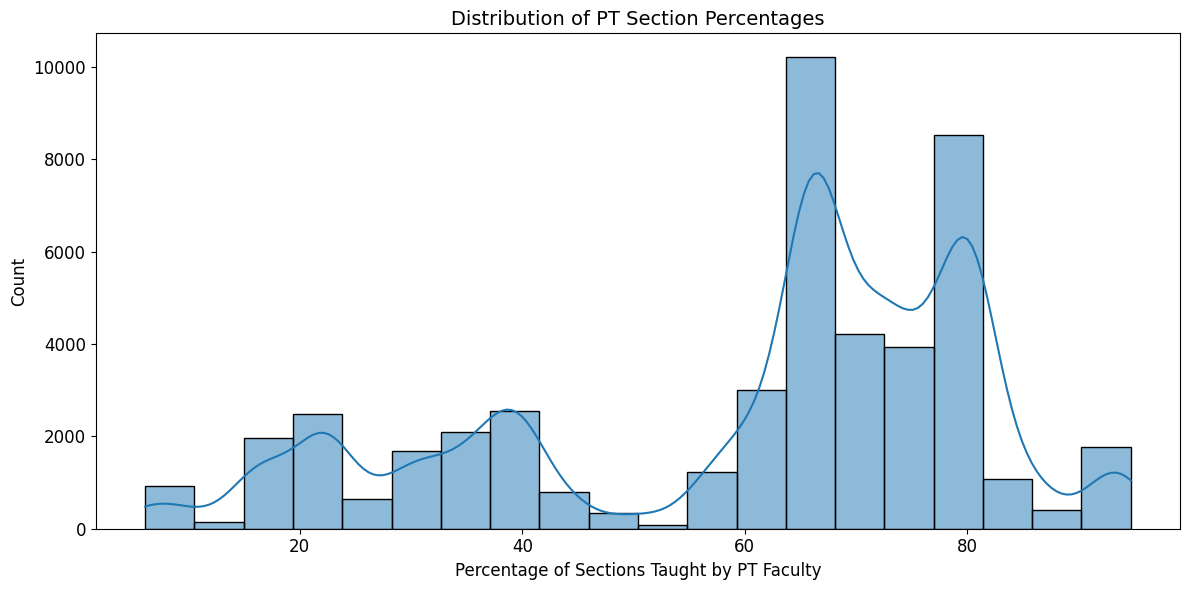

In [ ]:
if freshmen_data:
  summary_data = display_metrics(data)
else:
  summary_data = display_metrics(data)

summary_data

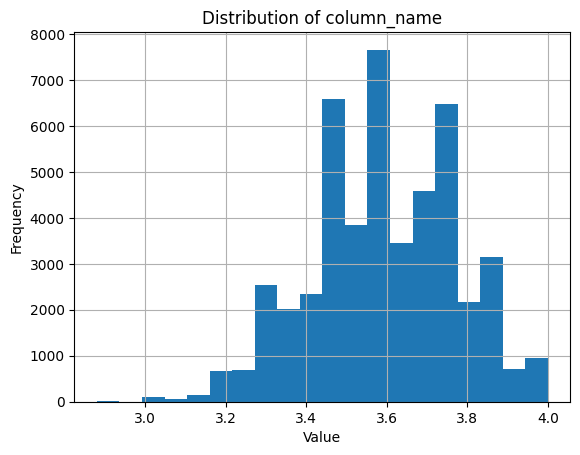

In [ ]:

  data['HSGPA'].hist(bins=20)
  plt.title('Distribution of column_name')
  plt.xlabel('Value')
  plt.ylabel('Frequency')
  plt.show()

## Step 4c: Check for collinearity

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
if freshmen_data:
  X = data[['PT', 'PRE_COVID', 'HSGPA', 'FEMALE', 'PELLSTATUS', 'RACE_MINORITY', 'PCT_PT_SECTION']]
else:
  X = data[['PT', 'PRE_COVID', 'ENROLLMENT', 'HSGPA', 'FEMALE', 'PELLSTATUS', 'RACE_MINORITY', 'PCT_PT_SECTION']]

X = sm.add_constant(X)

vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

##  Run a hierarchical linear regression

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
#data1=data.sample(frac=0.1, replace=False, random_state=1)

# Basic random intercepts model
if freshmen_data:
  formula = "GRADE_FINAL ~ PT + PCT_PT_SECTION + ENROLLMENT + PRE_COVID + HSGPA + FEMALE + PELLSTATUS + RACE_MINORITY"
else:
  formula = "GRADE_FINAL ~ PT + PCT_PT_SECTION + ENROLLMENT + PRE_COVID + HSGPA + C(CLASS) + FEMALE + PELLSTATUS + RACE_MINORITY"
mixed_model = sm.MixedLM.from_formula(
     formula=formula,
     groups=data["COURSE"],
    re_formula="~PT",
    data=data
)

mixed_results = mixed_model.fit(method='lbfgs') #cg
print(mixed_results.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: GRADE_FINAL 
No. Observations: 338251  Method:             REML        
No. Groups:       480     Scale:              0.4975      
Min. group size:  4       Log-Likelihood:     -363250.0779
Max. group size:  14385   Converged:          Yes         
Mean group size:  704.7                                   
----------------------------------------------------------
               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept      -0.583    0.053 -10.950 0.000 -0.687 -0.479
C(CLASS)[T.JR]  0.275    0.006  49.988 0.000  0.264  0.286
C(CLASS)[T.SO]  0.180    0.004  47.226 0.000  0.173  0.188
C(CLASS)[T.SR]  0.375    0.007  52.871 0.000  0.361  0.389
PT              0.164    0.012  13.183 0.000  0.140  0.189
PCT_PT_SECTION  0.000    0.000   1.049 0.294 -0.000  0.001
ENROLLMENT      0.001    0.000   6.150 0.000  0.000  0.001
PRE_COVI

       COURSE  PT_Sections  FT_Sections  Total_PT_Effect
49   BIOL232L          683           64         0.940802
427  PSYC210L          444           91         0.719075
127   COM302L           29          368         0.689743
350  MDIA120L          992          641         0.682667
115   COM186L           12           35         0.682189
347  MDIA101L          103          560         0.657101
315  HIST292L           76          137         0.654715
7    ACCT451N           82          268         0.639430
108  CMPT446N           12           47         0.628789
174  CRJU390L           30           51         0.597842
       COURSE  PT_Sections  FT_Sections  Total_PT_Effect
237   ENG271L          154          145        -0.227542
243   ENG334L           14           20        -0.238302
195  EDUC241N           15          131        -0.238651
293  FASH479L           28          174        -0.294195
298  FREN202L           20          111        -0.328917
437  PSYC362L          273     

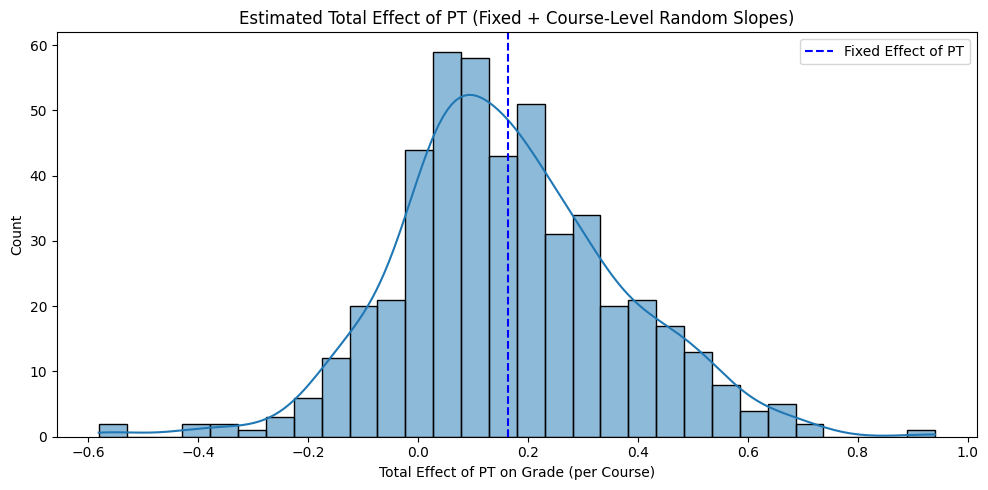

In [ ]:

pt_fixed = mixed_results.fe_params["PT"]


random_effects = mixed_results.random_effects


random_df = pd.DataFrame.from_dict(random_effects, orient='index')

if "PT" in random_df.columns:
    pt_slopes = random_df["PT"]
else:
    pt_slopes = random_df.iloc[:, 1]


random_df["Total_PT_Effect"] = pt_fixed + pt_slopes


random_df = random_df.reset_index().rename(columns={"index": "COURSE"})


course_counts = data.groupby(["COURSE", "PT"]).size().unstack(fill_value=0).reset_index()
course_counts.columns = ["COURSE", "FT_Sections", "PT_Sections"]  # assuming PT=0 is FT, PT=1 is PT


summary_df = pd.merge(random_df, course_counts, on="COURSE", how="left")


top_total = summary_df.sort_values(by="Total_PT_Effect", ascending=False)


print(top_total[["COURSE", "PT_Sections", "FT_Sections", "Total_PT_Effect"]].head(10))
print(top_total[["COURSE", "PT_Sections", "FT_Sections", "Total_PT_Effect"]].tail(10))

# 10. Plot
plt.figure(figsize=(10, 5))
sns.histplot(top_total["Total_PT_Effect"], bins=30, kde=True)
plt.axvline(pt_fixed, color="blue", linestyle="--", label="Fixed Effect of PT")
plt.title("Estimated Total Effect of PT (Fixed + Course-Level Random Slopes)")
plt.xlabel("Total Effect of PT on Grade (per Course)")
plt.legend()
plt.tight_layout()
plt.show()


## BAyesian Hierarchical modeling

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338251 entries, 0 to 491266
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PT              338251 non-null  int64  
 1   COURSE          338251 non-null  object 
 2   COURSE_SECTION  338251 non-null  object 
 3   PRE_COVID       338251 non-null  int64  
 4   ENROLLMENT      338251 non-null  int64  
 5   PCT_PT_SECTION  338251 non-null  float64
 6   AGE             338251 non-null  int64  
 7   CLASS           338251 non-null  object 
 8   HSGPA           338251 non-null  float64
 9   FEMALE          338251 non-null  int64  
 10  PELLSTATUS      338251 non-null  int64  
 11  RACE_MINORITY   338251 non-null  int64  
 12  GRADE_FINAL     338251 non-null  float64
dtypes: float64(3), int64(7), object(3)
memory usage: 36.1+ MB


In [ ]:
# List of predictors

predictors = (
    "PT",
    "PCT_PT_SECTION",
    "ENROLLMENT",
    "PRE_COVID",
    "HSGPA",
    "FEMALE",
    #"CLASS,"   for all undergraduates
    "PELLSTATUS",
    "RACE_MINORITY"
)

# Create the formula string
predictors_string = " + ".join(predictors)
dependent_variable = "GRADE_FINAL"
group = "COURSE"
predictors_string = " + ".join(predictors)

# Only Intercepts
formula = f"{dependent_variable} ~ {predictors_string} + (1 + PT | COURSE)"
formula


'GRADE_FINAL ~ PT + PCT_PT_SECTION + ENROLLMENT + PRE_COVID + HSGPA + FEMALE + PELLSTATUS + RACE_MINORITY + (1 + PT | COURSE)'

In [ ]:
priors = {
    # Fixed effects
    "PT": bmb.Prior("Normal", mu=0, sigma=0.5),
    "PCT_PT_SECTION": bmb.Prior("Normal", mu=0, sigma=0.5),
    "ENROLLMENT": bmb.Prior("Normal", mu=0, sigma=0.25),
    "PRE_COVID": bmb.Prior("Normal", mu=0, sigma=0.5),
    "HSGPA": bmb.Prior("Normal", mu=0, sigma=0.5),
    "FEMALE": bmb.Prior("Normal", mu=0, sigma=0.5),
    "PELLSTATUS": bmb.Prior("Normal", mu=0, sigma=0.5),
    "RACE_MINORITY": bmb.Prior("Normal", mu=0, sigma=0.5),
    "Intercept": bmb.Prior("Normal", mu=3.0, sigma=0.5),

    # ✅ Random effects
    "sd(COURSE|Intercept)": bmb.Prior("HalfNormal", sigma=0.5),
    "sd(COURSE|PT)": bmb.Prior("HalfNormal", sigma=0.25),

    # SE of the estimate
    "sigma": bmb.Prior("HalfNormal", sigma=0.5)
}



       Formula: GRADE_FINAL ~ PT + PCT_PT_SECTION + ENROLLMENT + PRE_COVID + HSGPA + FEMALE + PELLSTATUS + RACE_MINORITY + (1 + PT | COURSE)
        Family: gaussian
          Link: mu = identity
  Observations: 48138
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 3.0, sigma: 0.5)
            PT ~ Normal(mu: 0.0, sigma: 0.5)
            PCT_PT_SECTION ~ Normal(mu: 0.0, sigma: 0.5)
            ENROLLMENT ~ Normal(mu: 0.0, sigma: 0.25)
            PRE_COVID ~ Normal(mu: 0.0, sigma: 0.5)
            HSGPA ~ Normal(mu: 0.0, sigma: 0.5)
            FEMALE ~ Normal(mu: 0.0, sigma: 0.5)
            PELLSTATUS ~ Normal(mu: 0.0, sigma: 0.5)
            RACE_MINORITY ~ Normal(mu: 0.0, sigma: 0.5)
        
        Group-level effects
            1|COURSE ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.2678))
            PT|COURSE ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 4.6299))
        
        Auxiliary parameters
            sigma ~ HalfNormal(s

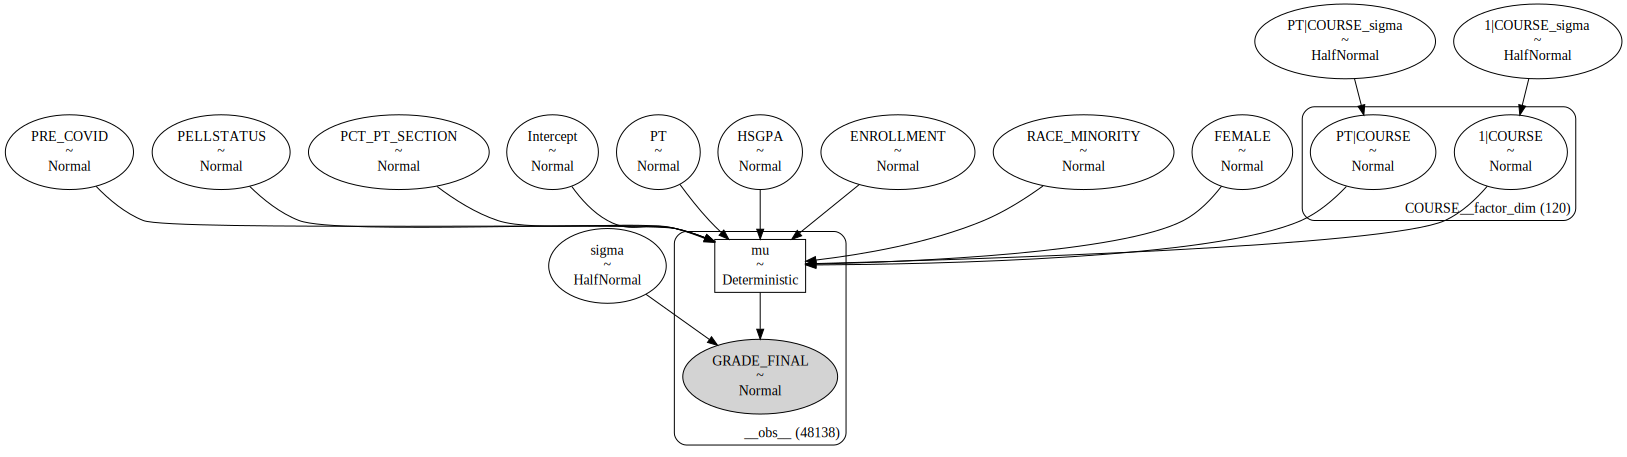

In [ ]:
# Build the Bambi model
model = bmb.Model(formula, data=data, priors=priors,family="gaussian", noncentered=False)

print(model)

# VisualiZe DAG
model.build()
model.graph(figsize=(4,6), name="./bambi_dag")

In [ ]:
start_time = time.time()

fitted = model.fit(draws=4000,tune=1000,
                   chains=4,
                   #cores=4,  # it may not work with more than one core
                   target_accept=0.95,
                  idata_kwargs={"log_likelihood": True})

end_time = time.time()

print(f"Time taken: {end_time - start_time} seconds")

Output()

Time taken: 395.7195417881012 seconds


In [ ]:
# Print divergences
divergences = np.any(fitted.sample_stats.diverging, axis=-1)


divergent_indices = np.where(divergences)[0]

if divergent_indices.size > 0:
    print("Divergences found at the following indices:")
    print(divergent_indices)
else:
    print("No divergences found.")

No divergences found.


AttributeError: 'set' object has no attribute 'get'

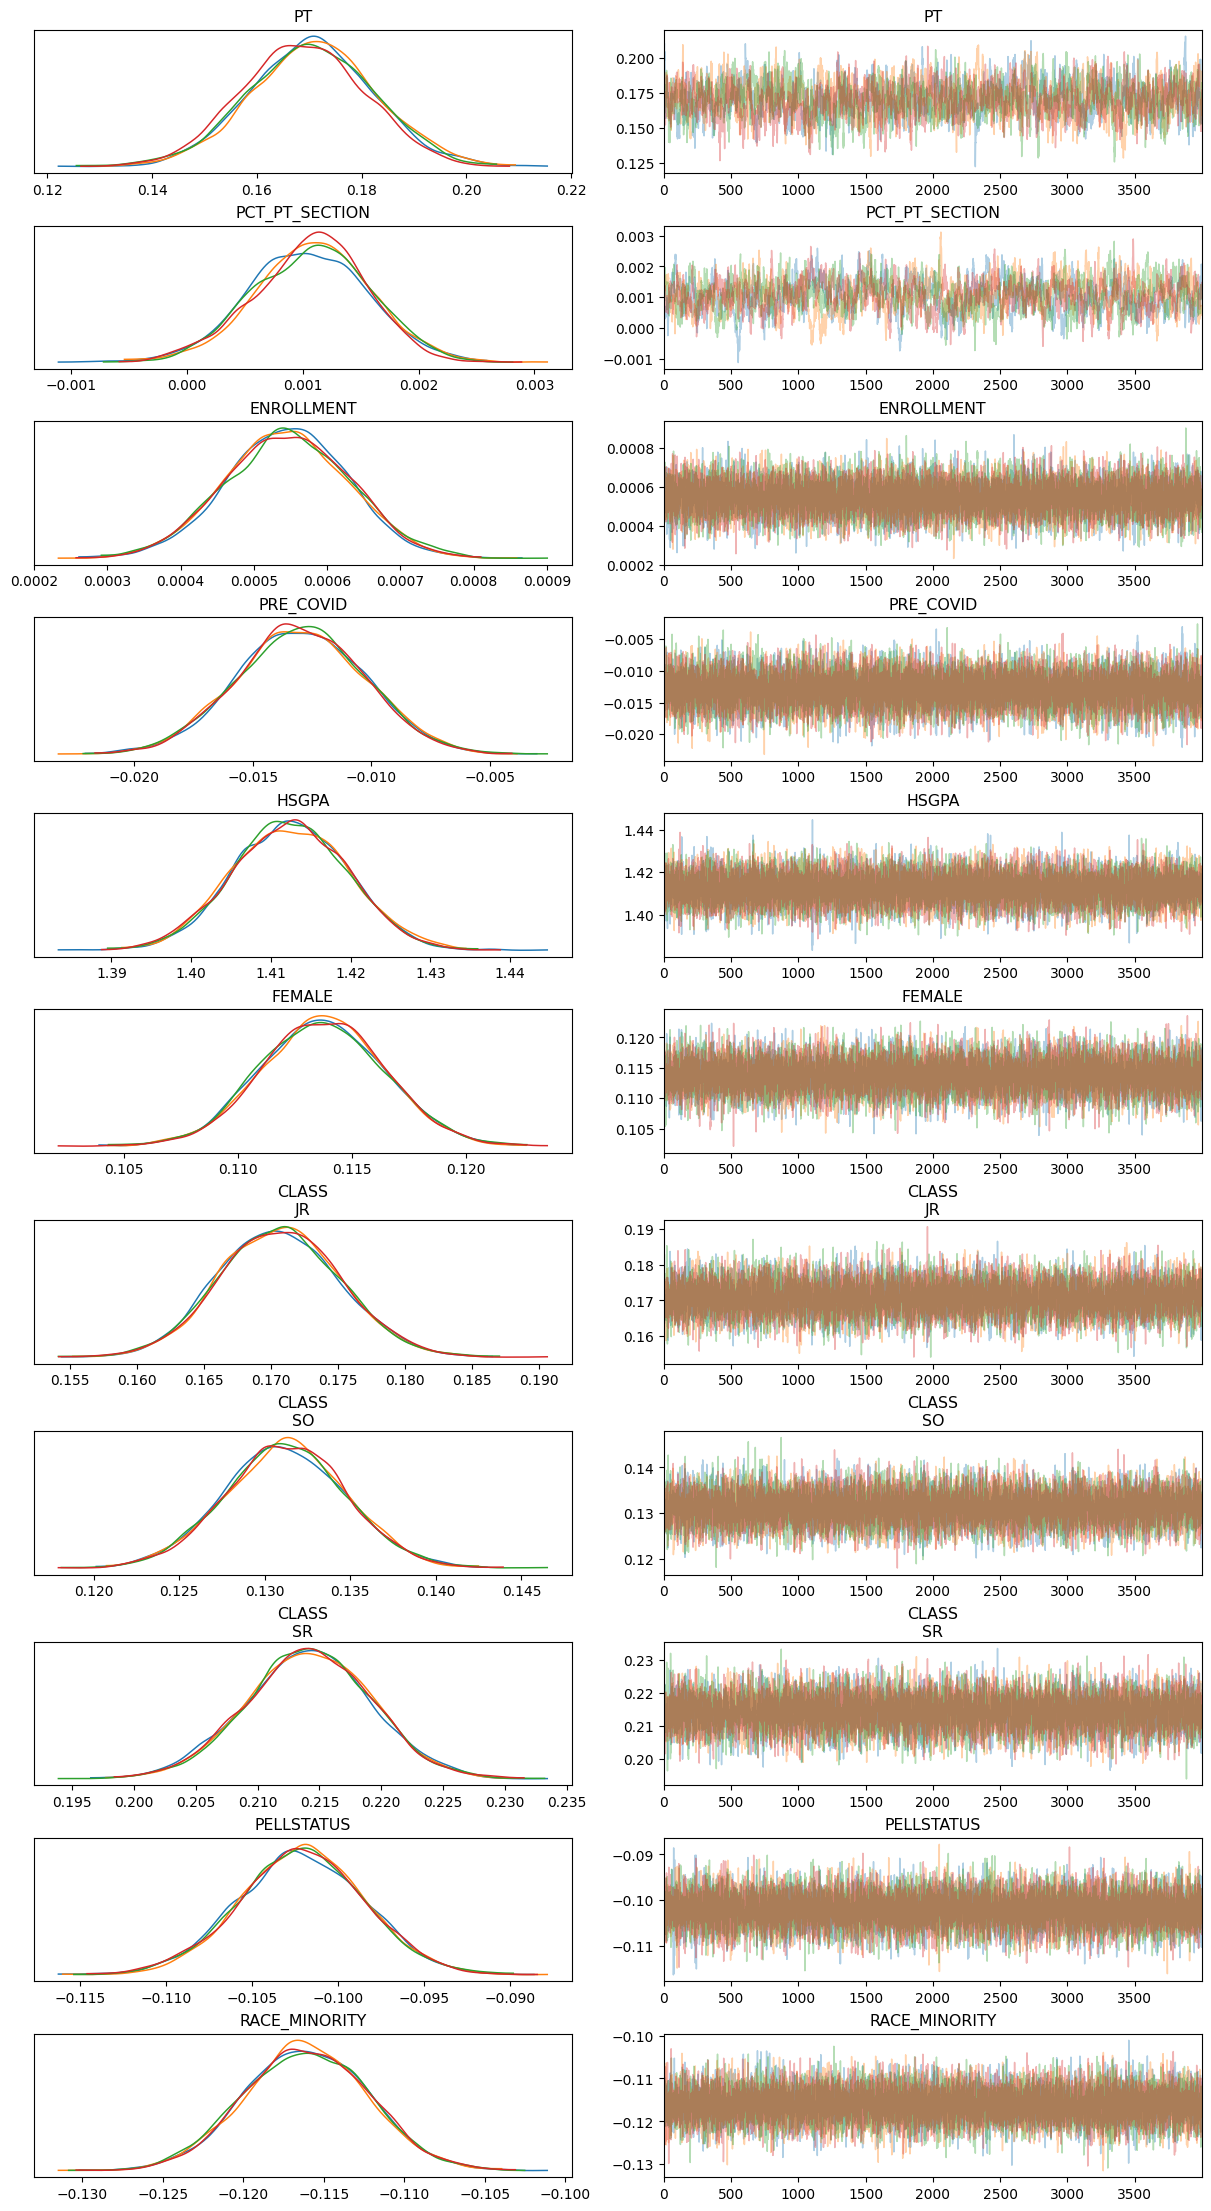

In [ ]:
import arviz as az
import matplotlib.pyplot as plt

# Select specific variables
var_names = [
    "PT",
    "PCT_PT_SECTION",
    "ENROLLMENT",
    "PRE_COVID",
    "HSGPA",
    "FEMALE",
    "CLASS",  # add it or remove it depending on freshmen or all undergrads
    "PELLSTATUS",
    "RACE_MINORITY"]


custom_labels = {
     "PT: PT instructor",
    "PCT_PT_SECTION: Percent PT (sections)",
    "ENROLLMENT: ENrollment",
    "PRE_COVID: Pre Covid Year",
    "HSGPA : High School GPA",
    "FEMALE: Female",
    "CLASS: Class",  # add it or remove it depending on freshmen or all undergrads
    "PELLSTATUS: Pell status",
    "RACE_MINORITY: Race minority"
}

# Plot trace
axes = az.plot_trace(fitted, var_names=var_names, compact=False, backend_kwargs={"layout": "constrained"})


for i, var in enumerate(var_names):
    for j in range(2):
        axes[i, j].set_title(custom_labels.get(var, var), fontsize=12)

plt.savefig("trace_plot.png", dpi=300, bbox_inches="tight")

plt.show()

from google.colab import files
files.download('trace_plot.png')

In [ ]:
filter_var_names_report(fitted)

['ENROLLMENT',
 'FEMALE',
 'HSGPA',
 'Intercept',
 'PCT_PT_SECTION',
 'PELLSTATUS',
 'PRE_COVID',
 'PT',
 'RACE_MINORITY',
 'sigma']

In [ ]:
# Print summary table
var_names = filter_var_names_report(fitted)
rope_min = -0.05
rope_max= 0.05
summary = add_rope_info(fitted, var_names, rope_min, rope_max, ropes=None)

summary = summary.drop(index="sigma", errors="ignore")


re_summary = extract_group_variance_summary(fitted)


summary_final = pd.concat([summary, re_summary], axis=0)


mask = summary_final.index.isin(["Group Var", "PT Var", "Group x PT Cov"])

summary_final.loc[mask] = summary_final.loc[mask].fillna("")

summary_final.round(3)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,% 95% HDI within ROPE
Intercept,-3.594,0.107,-3.797,-3.376,0.002,0.001,5008.0,8321.0,1.0,0.0
ENROLLMENT,0.002,0.001,0.001,0.004,0.0,0.0,24522.0,12413.0,1.0,100.0
FEMALE,0.098,0.008,0.082,0.113,0.0,0.0,38683.0,12120.0,1.0,0.0
HSGPA,1.832,0.022,1.789,1.874,0.0,0.0,36071.0,12334.0,1.0,0.0
PCT_PT_SECTION,0.001,0.001,-0.001,0.003,0.0,0.0,2266.0,4903.0,1.0,100.0
PELLSTATUS,-0.100,0.010,-0.120,-0.080,0.0,0.0,37664.0,12073.0,1.0,0.0
PRE_COVID,0.128,0.008,0.113,0.144,0.0,0.0,30910.0,12520.0,1.0,0.0
PT,0.183,0.027,0.129,0.236,0.0,0.0,3651.0,6291.0,1.0,0.0
RACE_MINORITY,-0.140,0.011,-0.161,-0.118,0.0,0.0,35761.0,11941.0,1.0,0.0
Group Var,0.090,0.014,0.066,0.120,,,,,,


Top 10 Positive PT Effects
       COURSE  Random_PT_Slope  Total_PT_Effect
14   BIOL232L         0.565014         0.748264
90   MDIA120L         0.428540         0.611790
65   FASH245N         0.417564         0.600814
84   MATH110L         0.410708         0.593959
86   MATH115L         0.358175         0.541426
59   ENSC101L         0.308295         0.491546
77   HIST296L         0.287793         0.471044
104  PSYC101L         0.279913         0.463163
102  POSC110L         0.262766         0.446017
37    ENG150L         0.243346         0.426597

Top 10 Negative PT Effects
       COURSE  Random_PT_Slope  Total_PT_Effect
55    ENG271L        -0.382101        -0.198851
60   FASH100L        -0.334332        -0.151081
70   HIST223L        -0.306805        -0.123554
18   CHEM111L        -0.305476        -0.122226
29   CSIS103L        -0.265254        -0.082003
85   MATH111L        -0.262434        -0.079184
39    ENG205L        -0.261207        -0.077956
116  SPAN106L        -0.249462   

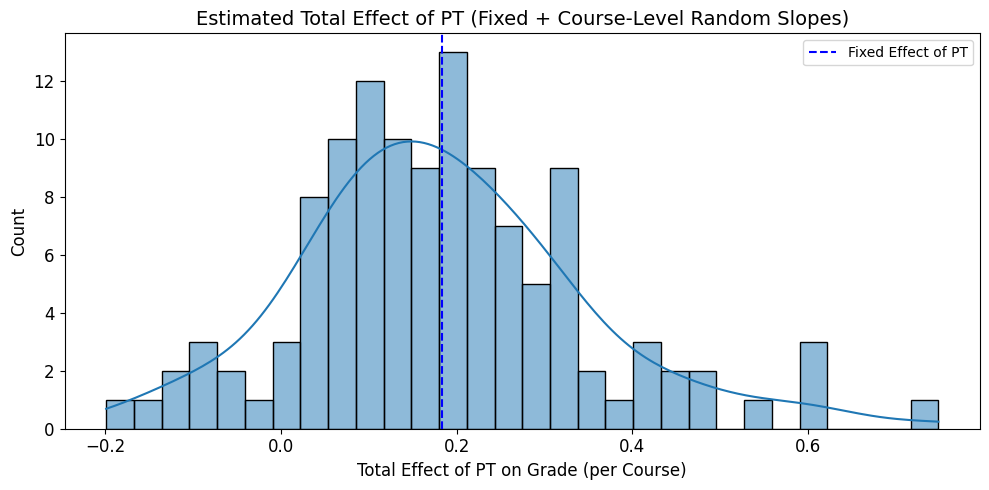

In [ ]:

pt_course_slopes = fitted.posterior["PT|COURSE"]  # shape: (chain, draw, course)
pt_course_slopes_mean = pt_course_slopes.mean(dim=("chain", "draw")).values


pt_fixed_mean = fitted.posterior["PT"].mean().values.item()


course_labels = fitted.posterior["PT|COURSE"].coords["COURSE__factor_dim"].values


pt_effect_df = pd.DataFrame({
    "COURSE": course_labels,
    "Random_PT_Slope": pt_course_slopes_mean,
})
pt_effect_df["Total_PT_Effect"] = pt_fixed_mean + pt_effect_df["Random_PT_Slope"]


top10 = pt_effect_df.sort_values("Total_PT_Effect", ascending=False).head(10)
bottom10 = pt_effect_df.sort_values("Total_PT_Effect", ascending=True).head(10)

print("Top 10 Positive PT Effects")
print(top10)
print("\nTop 10 Negative PT Effects")
print(bottom10)


plt.figure(figsize=(10, 5))
sns.histplot(pt_effect_df["Total_PT_Effect"], bins=30, kde=True)
plt.axvline(pt_fixed_mean, color="blue", linestyle="--", label="Fixed Effect of PT")
plt.title("Estimated Total Effect of PT (Fixed + Course-Level Random Slopes)",fontsize=14)
plt.xlabel("Total Effect of PT on Grade (per Course)",fontsize=12)
plt.ylabel("Count",fontsize=12)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()


plt.show()


In [ ]:
# Sanity check: plot distirbution of posterior fixed, rnadom and total PT effects for BIOL232L
import arviz as az
import matplotlib.pyplot as plt

course_name = "BIOL232L"
course_idx = list(fitted.posterior["PT|COURSE"].coords["COURSE__factor_dim"].values).index(course_name)

pt_random = fitted.posterior["PT|COURSE"][:, :, course_idx]
pt_fixed = fitted.posterior["PT"]

pt_total = pt_fixed + pt_random

pt_effect_idata = az.from_dict(
    posterior={
        "Fixed_PT": pt_fixed.values,
        "Random_PT_BIOL232L": pt_random.values,
        "Total_PT_BIOL232L": pt_total.values
    }
)

pt_effect_idata.posterior = pt_effect_idata.posterior.rename({
    "Fixed_PT": "Fixed Effect",
    "Random_PT_BIOL232L": "Random Effect (BIOL232L)",
    "Total_PT_BIOL232L": "Total Effect (BIOL232L)"
})

az.plot_posterior(
    pt_effect_idata,
    var_names=["Fixed Effect", "Random Effect (BIOL232L)", "Total Effect (BIOL232L)"],
    hdi_prob=0.95,
    figsize=(12, 4),
    textsize=12,
)
plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

In [ ]:
fitted.posterior["PT|COURSE"].coords

Coordinates:
  * chain               (chain) int64 32B 0 1 2 3
  * draw                (draw) int64 32kB 0 1 2 3 4 ... 3995 3996 3997 3998 3999
  * COURSE__factor_dim  (COURSE__factor_dim) <U8 4kB 'ACCT203N' ... 'SPAN210L'

In [ ]:
print(list(fitted.posterior.data_vars))

['1|COURSE', '1|COURSE_sigma', 'ENROLLMENT', 'FEMALE', 'HSGPA', 'Intercept', 'PCT_PT_SECTION', 'PELLSTATUS', 'PRE_COVID', 'PT', 'PT|COURSE', 'PT|COURSE_sigma', 'RACE_MINORITY', 'sigma']


In [ ]:
print("1|COURSE_sigma shape:", fitted.posterior["1|COURSE_sigma"].values.shape)
print("PT|COURSE_sigma shape:", fitted.posterior["PT|COURSE_sigma"].values.shape)
print("1|COURSE shape:", fitted.posterior["1|COURSE"].values.shape)
print("PT|COURSE shape:", fitted.posterior["PT|COURSE"].values.shape)

1|COURSE_sigma shape: (4, 4000)
PT|COURSE_sigma shape: (4, 4000)
1|COURSE shape: (4, 4000, 120)
PT|COURSE shape: (4, 4000, 120)
